In [1]:
from random import random, randint
import numpy as np
from classes import Bandit, Environment


In [2]:
from cliffworld import step_cliffworld, init_cliffworld, reset_cliffworld

env_kwargs = { "shape": (12,4), "start": (0,0), "end": (11,0),
               "cliff": [ [0,i] for i in range(1,11) ]}
env = Environment(4, step_cliffworld, init_cliffworld, reset_cliffworld, env_kwargs)

In [3]:

def init_q_learn(B, kwargs):
    B.N_arms = kwargs['N_arms'] 
    B.context = env.reset()
    B.q_table = { B.context: np.random.uniform(low=-1, high=1, size=B.N_arms) }
    B.alpha = kwargs['alpha']
    B.discount = kwargs['discount']
    B.eps = kwargs['eps']
    B.eps_reduction = kwargs['eps_reduction']
    return

def q_learn(B):
    p = random()
    if p < B.eps:
        i = np.random.randint(0, B.N_arms)
        return i
    else:
        best = (-float('inf'),None)
        for i in range(B.N_arms):
            if B.q_table[B.context][i] >= best[0]:
                best = (B.q_table[B.context][i], i)
        return best[1]

def update_q_learn(B, arm, reward, observation, done = False):
    new_context = observation
    if new_context not in B.q_table:
        B.q_table[new_context] = np.random.uniform(low=-1, high=1, size=B.N_arms)
    Qmax = max(B.q_table[new_context])
    B.q_table[B.context][arm] += B.alpha * ( reward + B.discount * Qmax - B.q_table[B.context][arm] )
    B.context = new_context
    if done:
        B.eps -= B.eps_reduction
    return
    

In [19]:
kwargs = {"N_arms": 4, "alpha": 0.2, "discount": 0.9, "eps": 0.1, "eps_reduction": 0.0}

B = Bandit(env, q_learn, update_q_learn, init_q_learn, kwargs )

rewards = []
all_weights = []
counter = 0
#for i in range(100000):
counter = 0
interval = 25
best_return = -200
mean_return = -200
while mean_return < -25:
    done = False
    counter += 1
    if counter%interval == 0:
        mean_return = sum(rewards[-interval:])/float(interval)
        print( counter, "\t", mean_return, "\t", B.eps )
    total_return = 0
    while not done:
        #env.render()
        arm = B.policy(B)
        observation, reward, done, info = env.step(arm)
        B.update(B, arm, reward, observation, done)
        total_return += reward
        if done:
            rewards.append( total_return )
            env.reset()
            if total_return > best_return:
                best_return = total_return
            break
env.close()
print( "Done after ", counter, " episodes" )
print(best_return)

25 	 -137.6 	 0.1
50 	 -153.96 	 0.1
75 	 -143.16 	 0.1
100 	 -124.64 	 0.1
125 	 -110.68 	 0.1
150 	 -97.32 	 0.1
175 	 -80.24 	 0.1
200 	 -66.44 	 0.1
225 	 -75.08 	 0.1
250 	 -53.92 	 0.1
275 	 -56.4 	 0.1
300 	 -45.76 	 0.1
325 	 -42.36 	 0.1
350 	 -53.92 	 0.1
375 	 -37.8 	 0.1
400 	 -35.76 	 0.1
425 	 -31.52 	 0.1
450 	 -28.88 	 0.1
475 	 -39.8 	 0.1
500 	 -42.16 	 0.1
525 	 -37.96 	 0.1
550 	 -40.76 	 0.1
575 	 -45.4 	 0.1
600 	 -30.0 	 0.1
625 	 -42.84 	 0.1
650 	 -46.04 	 0.1
675 	 -32.72 	 0.1
700 	 -42.76 	 0.1
725 	 -37.52 	 0.1
750 	 -39.52 	 0.1
775 	 -36.84 	 0.1
800 	 -42.84 	 0.1
825 	 -39.28 	 0.1
850 	 -32.68 	 0.1
875 	 -50.96 	 0.1
900 	 -36.2 	 0.1
925 	 -32.0 	 0.1
950 	 -46.96 	 0.1
975 	 -39.36 	 0.1
1000 	 -36.92 	 0.1
1025 	 -36.0 	 0.1
1050 	 -40.08 	 0.1
1075 	 -40.48 	 0.1
1100 	 -39.56 	 0.1
1125 	 -43.76 	 0.1
1150 	 -47.32 	 0.1
1175 	 -39.88 	 0.1
1200 	 -32.0 	 0.1
1225 	 -47.44 	 0.1
1250 	 -28.2 	 0.1
1275 	 -43.96 	 0.1
1300 	 -36.32 	 0.1
1325 	 -

In [6]:
def init_sarsa(B, kwargs):
    B.N_arms = kwargs['N_arms'] 
    B.context = env.reset()
    B.q_table = { B.context: [ 0 for arm in range(B.N_arms) ] }
    #B.q_table = { B.context: np.random.uniform(low=-1, high=1, size=B.N_arms) }
    B.alpha = kwargs['alpha']
    B.discount = kwargs['discount']
    B.eps = kwargs['eps']
    B.eps_reduction = kwargs['eps_reduction']
    B.next_arm = None
    return

def sarsa(B):
    p = random()
    if p < B.eps:
        i = np.random.randint(0, B.N_arms)
        return i
    else:
        best = (-float('inf'),None)
        for i in range(B.N_arms):
            if B.q_table[B.context][i] >= best[0]:
                best = (B.q_table[B.context][i], i)
        return best[1]

from copy import deepcopy
def update_sarsa(B, arm, reward, observation, done = False):
    new_context = observation
    old_context = deepcopy(B.context)
    if new_context not in B.q_table:
        B.q_table[new_context] = [ 0 for arm in range(B.N_arms) ]
    B.context = new_context
    
    if done:
        B.eps -= B.eps_reduction
        B.q_table[old_context][arm] += B.alpha * ( reward - B.q_table[old_context][arm] )
    else:
        B.next_arm = B.policy(B)
        Qnext = B.q_table[new_context][B.next_arm]
        B.q_table[old_context][arm] += B.alpha * ( reward + B.discount * Qnext - B.q_table[old_context][arm] ) 
    return
    

In [10]:
kwargs = {"N_arms": 4, "alpha": 0.2, "discount": 0.9, "eps": 0.1, "eps_reduction": 0.00}

B = Bandit(env, sarsa, update_sarsa, init_sarsa, kwargs )

rewards2 = []
all_weights = []
counter = 0
interval = 25
best_return = -200
mean_return = -200
while mean_return < -20 and counter < 1000:
    done = False
    counter += 1
    if counter%interval == 0:
        mean_return = sum(rewards[-interval:])/float(interval)
        print( counter, "\t", mean_return, "\t", B.eps )
    total_return = 0
    while not done:
        #env.render()
        arm = B.policy(B) if B.next_arm is None else B.next_arm
        observation, reward, done, info = env.step(arm)
        B.update(B, arm, reward, observation, done)
        total_return += reward
        if done:
            rewards2.append( total_return )
            B.context = env.reset()
            B.next_arm = None
            if total_return > best_return:
                best_return = total_return
            break
env.close()
print( "Done after ", counter, " episodes" )
print(best_return)

25 	 -21.08 	 0.1
50 	 -21.08 	 0.1
75 	 -21.08 	 0.1
100 	 -21.08 	 0.1
125 	 -21.08 	 0.1
150 	 -21.08 	 0.1
175 	 -21.08 	 0.1
200 	 -21.08 	 0.1
225 	 -21.08 	 0.1
250 	 -21.08 	 0.1
275 	 -21.08 	 0.1
300 	 -21.08 	 0.1
325 	 -21.08 	 0.1
350 	 -21.08 	 0.1
375 	 -21.08 	 0.1
400 	 -21.08 	 0.1
425 	 -21.08 	 0.1
450 	 -21.08 	 0.1
475 	 -21.08 	 0.1
500 	 -21.08 	 0.1
525 	 -21.08 	 0.1
550 	 -21.08 	 0.1
575 	 -21.08 	 0.1
600 	 -21.08 	 0.1
625 	 -21.08 	 0.1
650 	 -21.08 	 0.1
675 	 -21.08 	 0.1
700 	 -21.08 	 0.1
725 	 -21.08 	 0.1
750 	 -21.08 	 0.1
775 	 -21.08 	 0.1
800 	 -21.08 	 0.1
825 	 -21.08 	 0.1
850 	 -21.08 	 0.1
875 	 -21.08 	 0.1
900 	 -21.08 	 0.1
925 	 -21.08 	 0.1
950 	 -21.08 	 0.1
975 	 -21.08 	 0.1
1000 	 -21.08 	 0.1
Done after  1000  episodes
-16


In [20]:
arrow = [ "<", ">", "^", "v" ]

grid = np.zeros( env.grid.shape, dtype=int ) 
grid = grid.tolist()
for i, j in B.q_table:
    amax = np.argmax(B.q_table[(i,j)])
    grid[i][j] = arrow[amax]

i, j = env.end
grid[i][j] = "x"

for j in range(4):
    for i in range(12):
        print( grid[i][j], end="\t")
    print("\n")

v	0	0	0	0	0	0	0	0	0	0	x	

>	>	>	>	>	>	>	>	>	>	>	^	

>	v	v	^	>	>	>	>	^	^	^	^	

^	>	v	<	>	>	>	>	>	>	^	^	



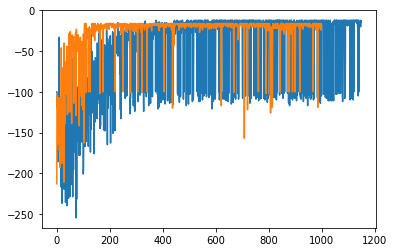

In [14]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.plot(rewards2)
plt.show()

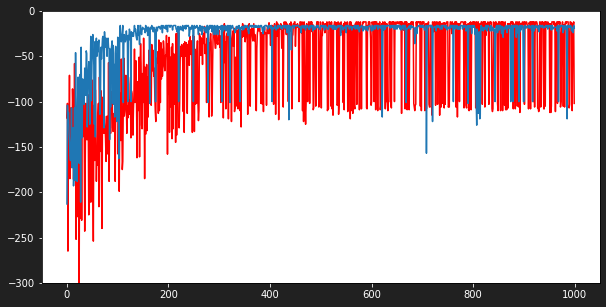

In [29]:
fig, ax = plt.subplots( figsize=(10,5) )
ax.plot( rewards[:1000], c='red')
ax.plot( rewards2, c='C0' )
fig.patch.set_facecolor('#212121')
ax.tick_params(colors='white')
ax.set_ylim(-300,0)
plt.show()

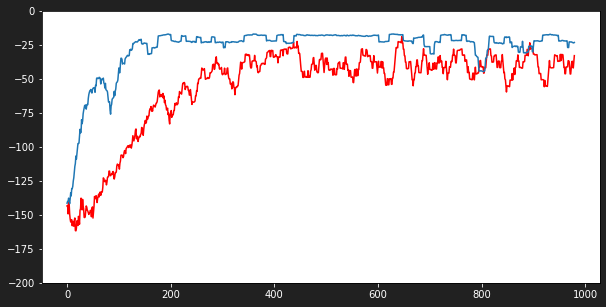

In [32]:
N = 20
R = [ sum(rewards[i:i+N])/float(N) for i in range(1000-N) ]
R2 = [ sum(rewards2[i:i+N])/float(N) for i in range(1000-N) ]

fig, ax = plt.subplots( figsize=(10,5) )
ax.plot( R, c='red')
ax.plot( R2, c='C0' )
fig.patch.set_facecolor('#212121')
ax.tick_params(colors='white')
ax.set_ylim(-200,0)
plt.show()